In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")


Here we load the dataset 
keeping the original name obtained from downloading on kaggle for convenient analysis for others 
Please keep the dataset in CustomerChurnPrediction/
It will be efficient and effective both 

In [2]:

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')


Now we will be performing some exploratoratory data analysis. For the analysis purpose we need to perform some changes to have an initial look we will straightaway move with some library features and then try to use our common logical understanding to maybe eliminate the need for that. Maybe we can choose to not execute this code and choose to change it. 

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

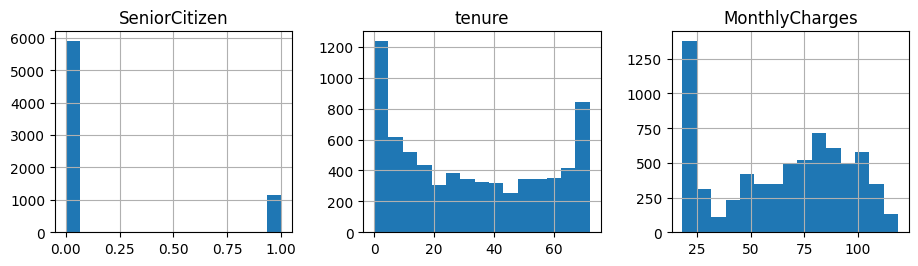

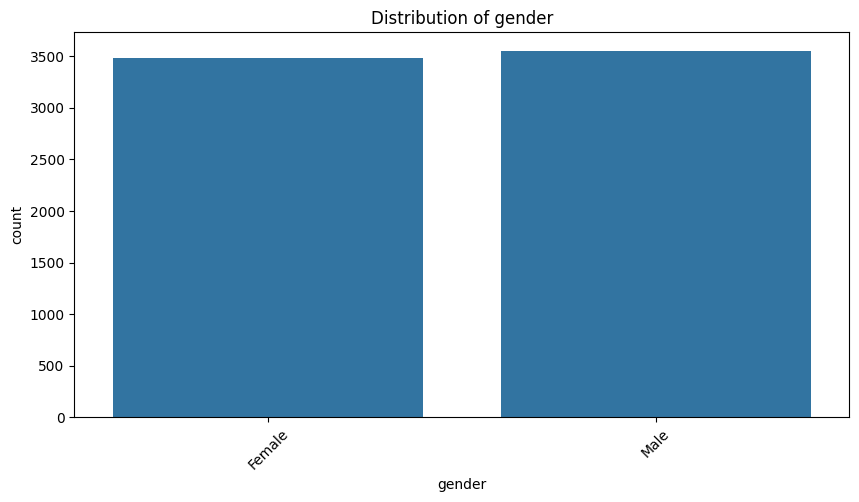

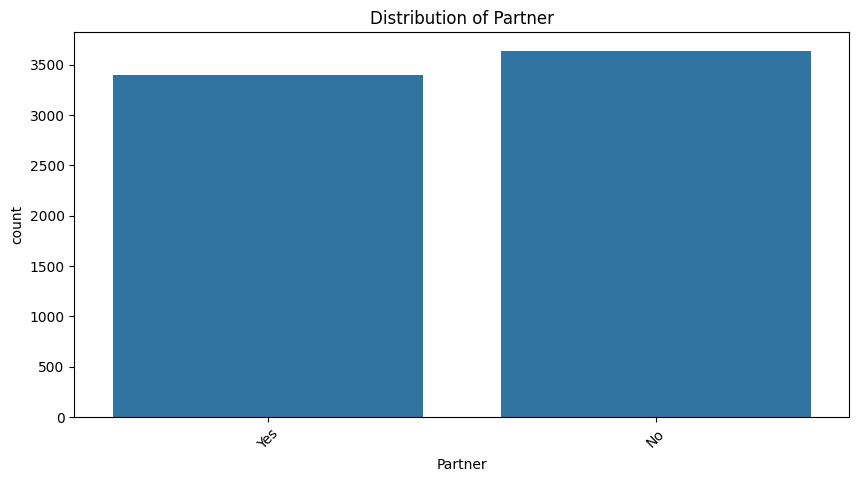

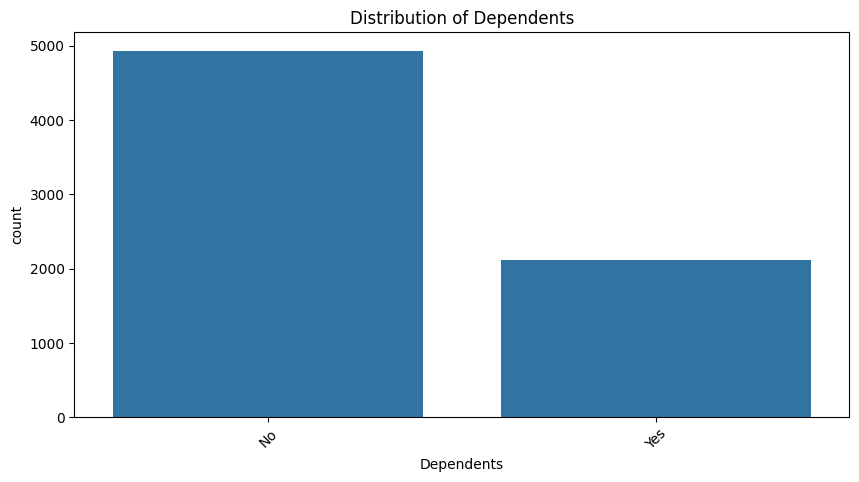

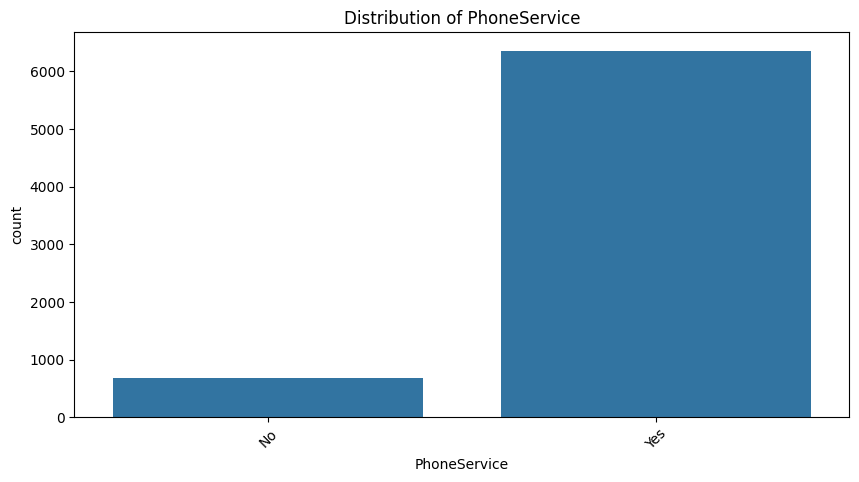

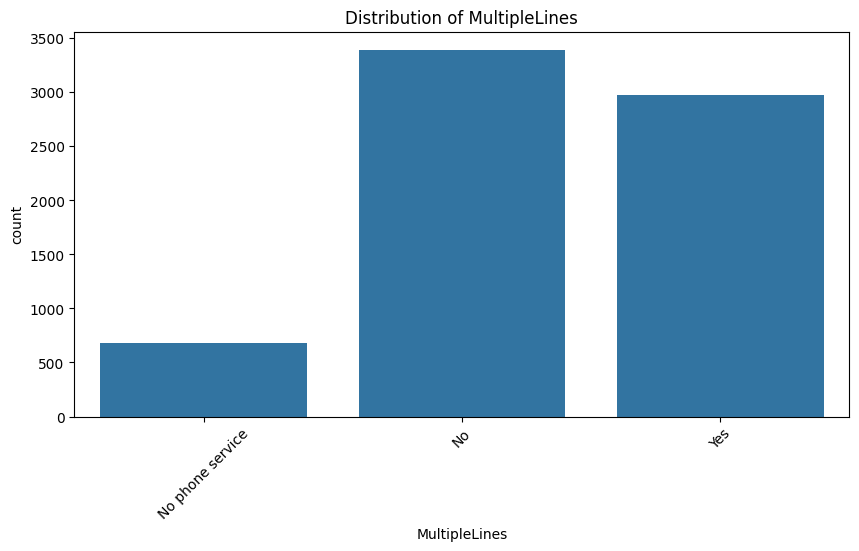

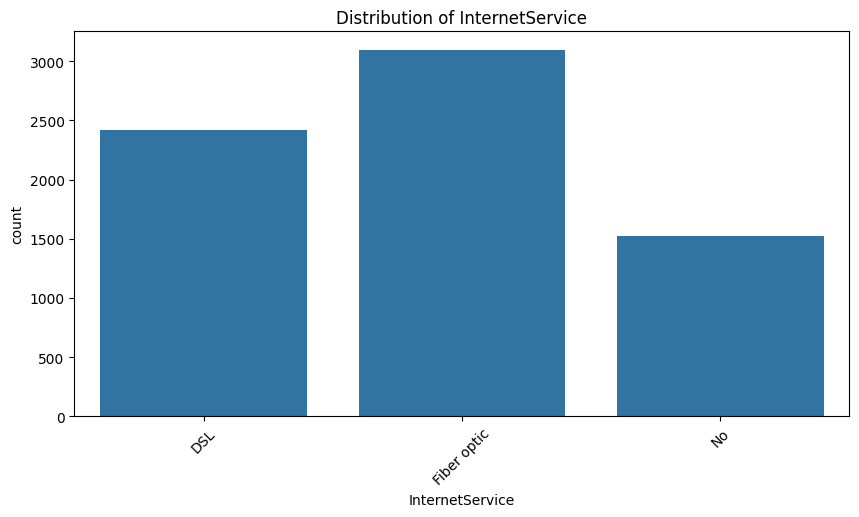

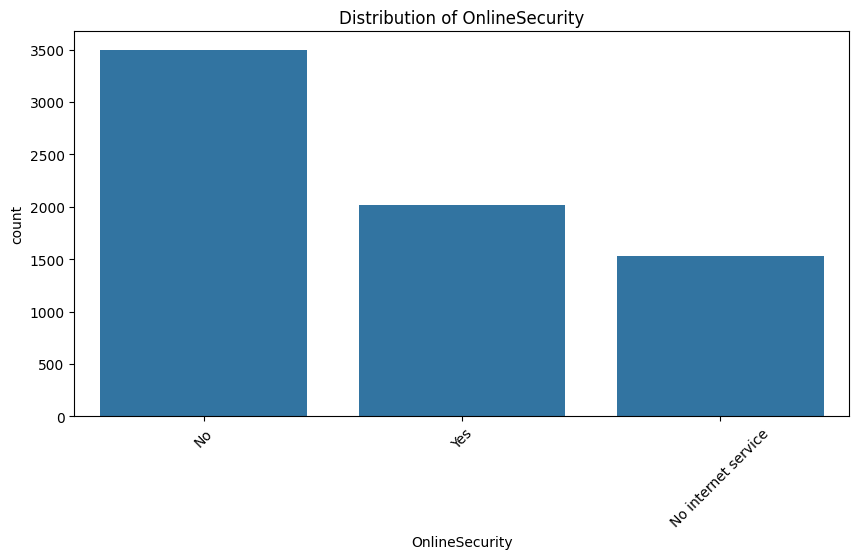

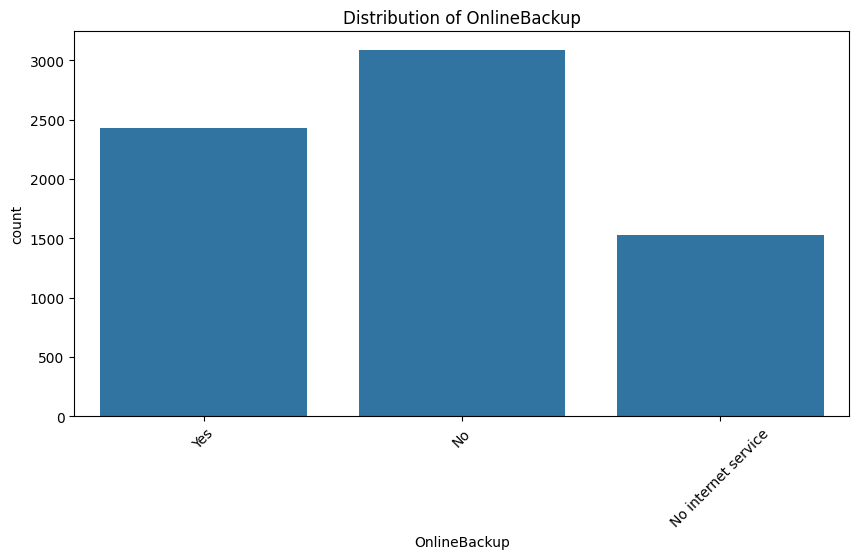

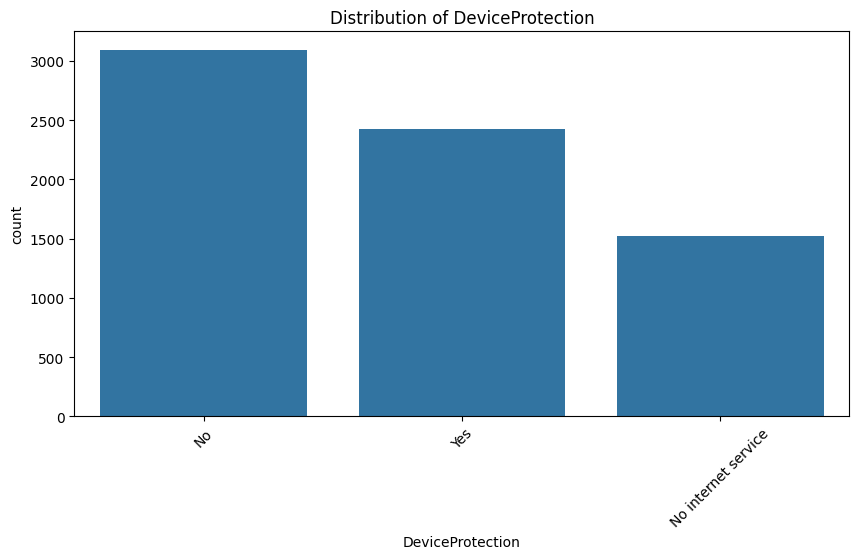

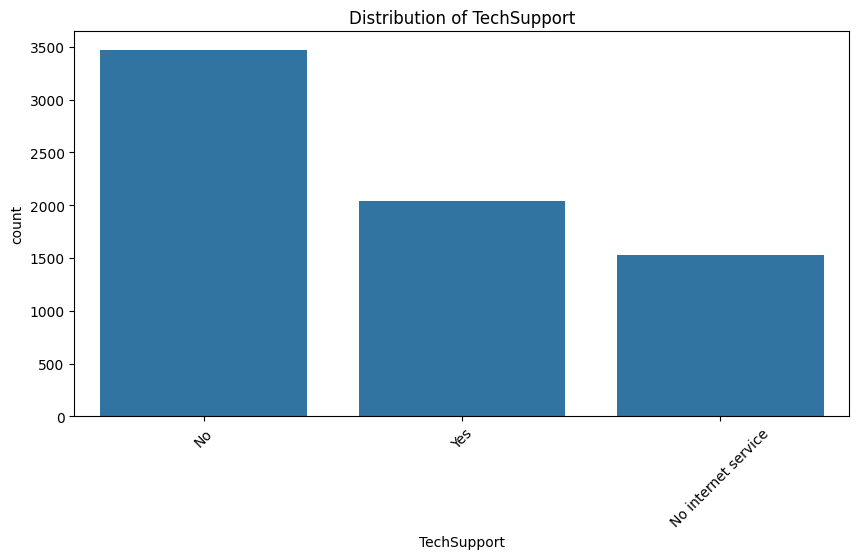

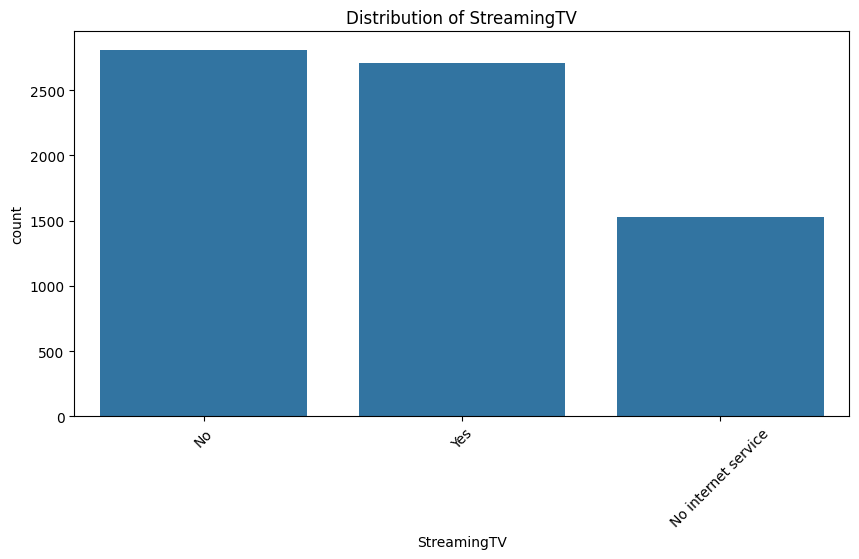

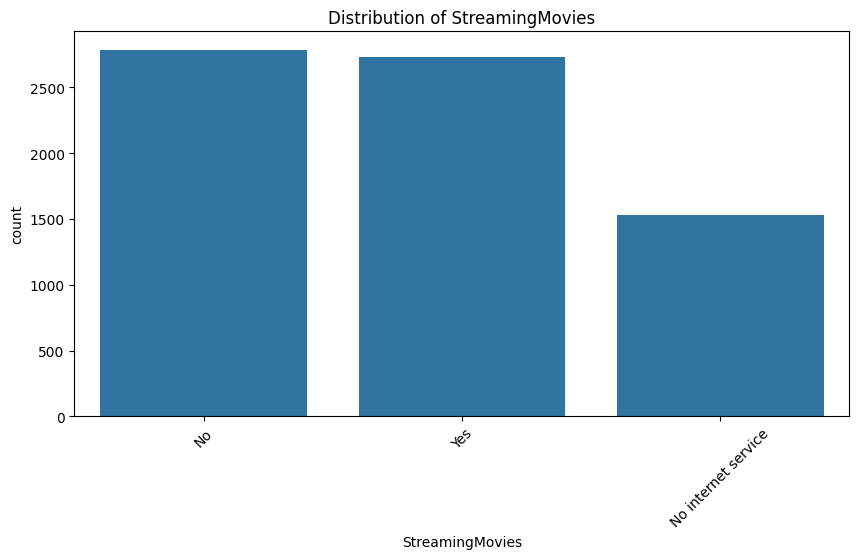

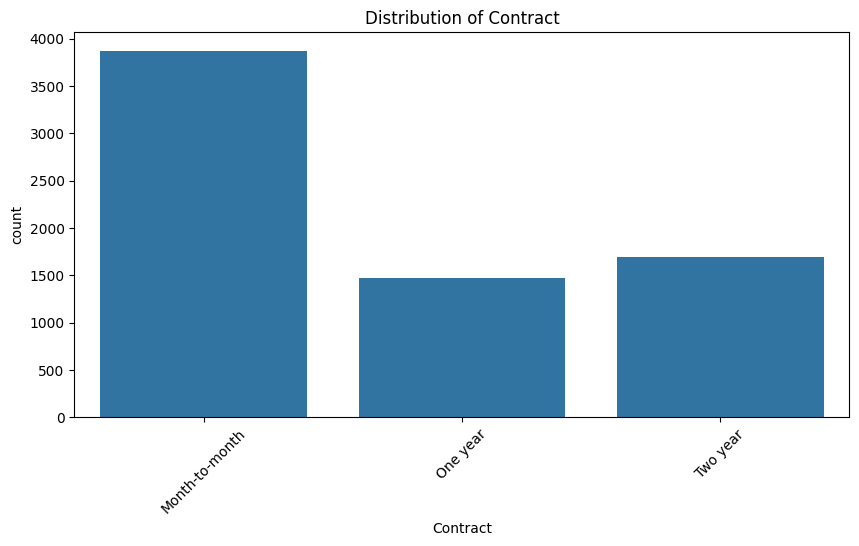

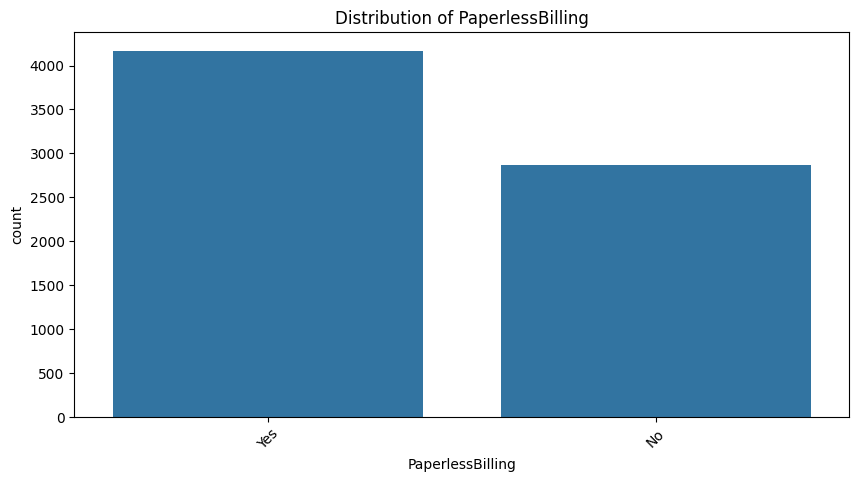

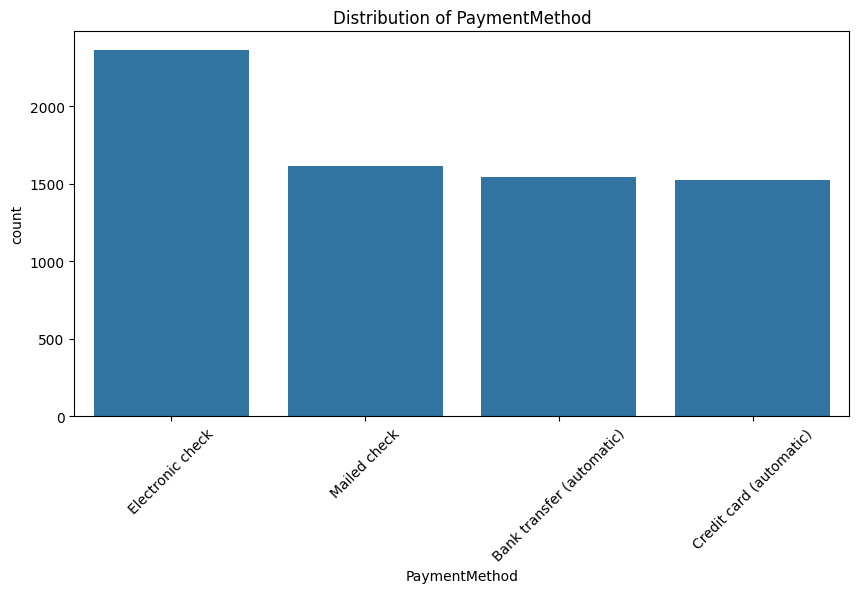

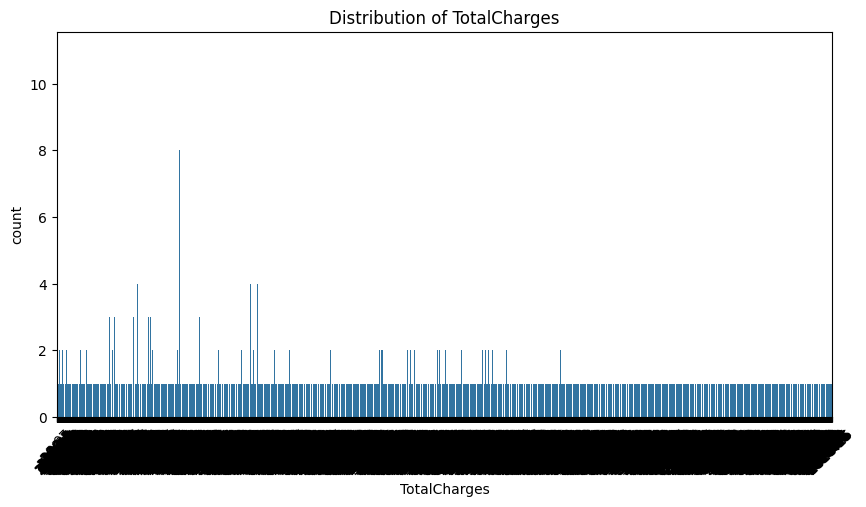

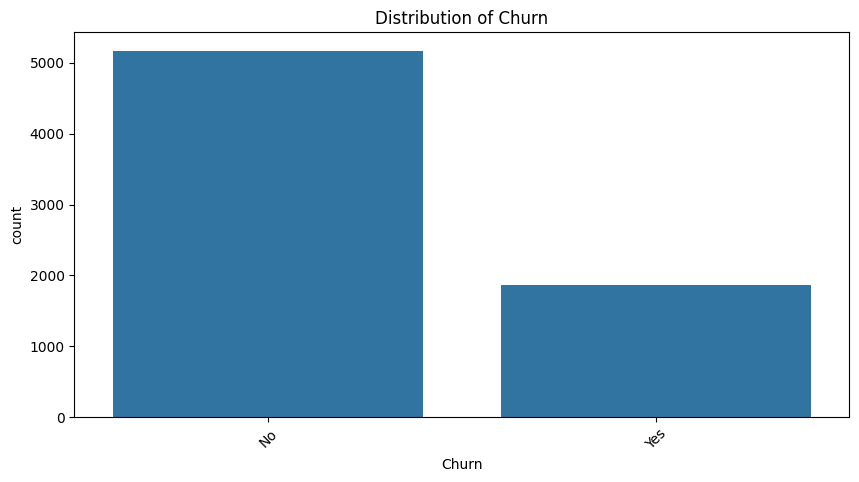

Unique values in gender: ['Female' 'Male']
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['No' 'Yes']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes']
Unique values in OnlineBackup: ['Yes' 'No']
Unique values in DeviceProtection: ['No' 'Yes']
Unique values in TechSupport: ['No' 'Yes']
Unique values in StreamingTV: ['No' 'Yes']
Unique values in StreamingMovies: ['No' 'Yes']
Unique values in Contract: ['Month' 'One year' 'Two year']
Unique values in PaperlessBilling: ['Yes' 'No']
Unique values in PaymentMethod: ['Electronic check' 'Mailed c

In [3]:
# Overview of the dataset
print(df.head())
print(df.info())
# a description for us to get a taste of data as to how it looks and behaves 
# the main idea 
print(df.describe())

# Check for missing values
print(df.isnull().sum())

df.drop('customerID' , axis=1 , inplace=True)

# Visualize distributions of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))

# Visualize distributions of categorical features
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()



#convert no internet service to no as there is a column with internet service
df['OnlineSecurity']=df['OnlineSecurity'].replace('No internet service','No')
df['OnlineBackup']=df['OnlineBackup'].replace('No internet service','No')
df['DeviceProtection']=df['DeviceProtection'].replace('No internet service','No')
df['TechSupport']=df['TechSupport'].replace('No internet service','No')
df['StreamingTV']=df['StreamingTV'].replace('No internet service','No')
df['StreamingMovies']=df['StreamingMovies'].replace('No internet service','No')
df['MultipleLines']=df['MultipleLines'].replace('No phone service','No')
df['Contract']=df['Contract'].replace('Month-to-month','Month')
for col in df.columns:
    print(f"Unique values in {col}: {df[col].unique()}") 

df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 60, 72 , np.inf], labels=[1, 2, 3, 4, 5, 6])
df.dropna()



# Handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Drop irrelevant columns
# df.drop(['customerID'], axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_features:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

for column in df.columns: 
    print('Unique values:' , column , df[column].unique())
# Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


As the plot shows equal number of males and females gender column will not skew data and will be an important feature

                    gender  SeniorCitizen   Partner  Dependents    tenure  \
gender            1.000000      -0.001874 -0.001808    0.010517  0.005106   
SeniorCitizen    -0.001874       1.000000  0.016479   -0.211185  0.016567   
Partner          -0.001808       0.016479  1.000000    0.452676  0.379697   
Dependents        0.010517      -0.211185  0.452676    1.000000  0.159712   
tenure            0.005106       0.016567  0.379697    0.159712  1.000000   
PhoneService     -0.006488       0.008576  0.017706   -0.001762  0.008448   
MultipleLines    -0.008414       0.142948  0.142057   -0.024526  0.331941   
InternetService  -0.000863      -0.032310  0.000891    0.044590 -0.030359   
OnlineSecurity   -0.017021      -0.038653  0.143106    0.080972  0.327203   
OnlineBackup     -0.013773       0.066572  0.141498    0.023671  0.360277   
DeviceProtection -0.002105       0.059428  0.153786    0.013963  0.360653   
TechSupport      -0.009212      -0.060625  0.119999    0.063268  0.324221   

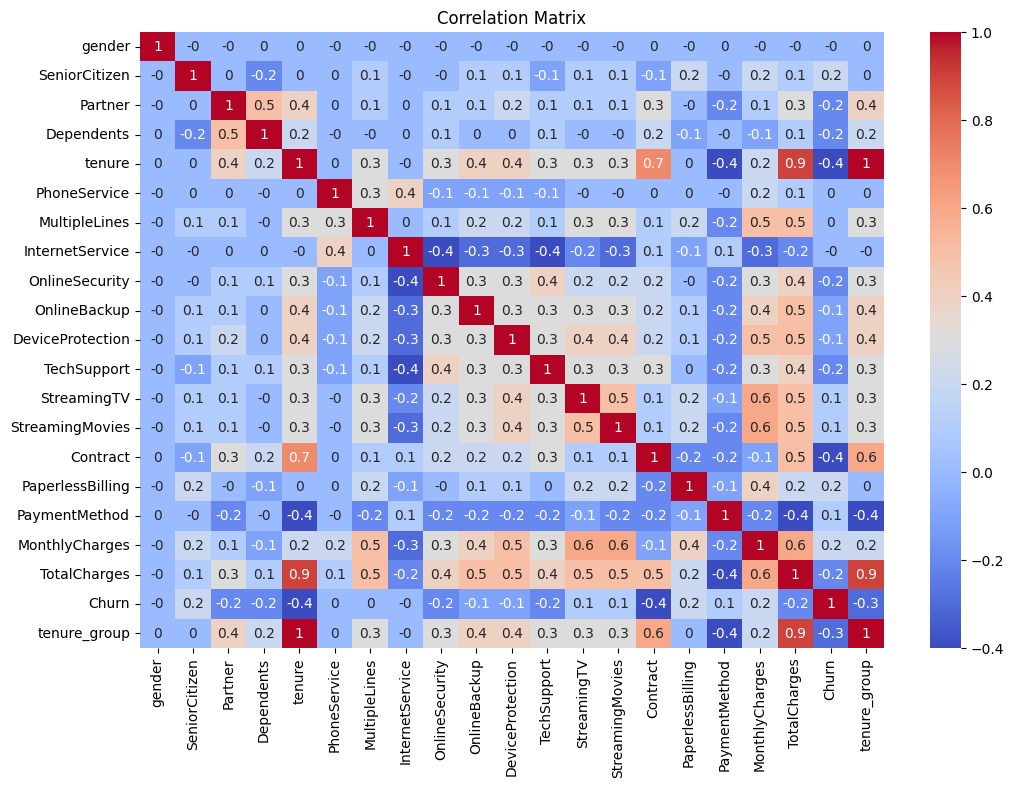

In [4]:
print(df.corr())
# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr().round(1), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The previous analysis clearly shows me that total charges and tenure are highly correlated , whatever I have done till now is done only for the purpose of visualization. My udnerstanding does not allow me to have label encoding used in cases where I can use logical encoding methods myself. With an understanding of that logic I'll use. 

I know for a fact that Internet service could be no also and hence no internet service value in certain columns seems useless.

Other correlated features in my opinion Contract and tenure , maybe total charges and monthly charges. 

It is logical to also categorize the tenure to effectively utilize bagging. 

All the previous steps will be a part of exploratory data analysis only proper preprocessing will take place in the next block.
My further analysis with box plots and violin plots is deleted from the notebook to not overcomplicate the understanding for the evaluaters.

For feature selection we went around using chi square statistic along with pearson correlation and heatmaps. There was an earlier thought to drop the correlated feature but there was only one with 0.9 correlation so dropping on the whim was not right. 

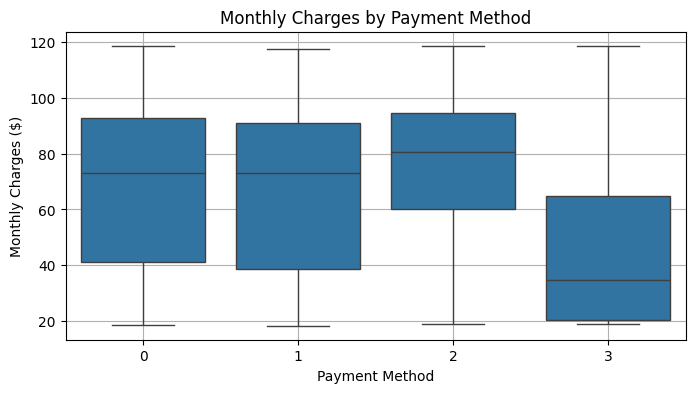

In [5]:
# payment methods vs monthly charges
plt.figure(figsize=(8, 4))
sns.boxplot(x='PaymentMethod', y='MonthlyCharges', data=df)
plt.title('Monthly Charges by Payment Method')
plt.ylabel('Monthly Charges ($)' , )
plt.xlabel('Payment Method')
plt.grid(True)
plt.show()


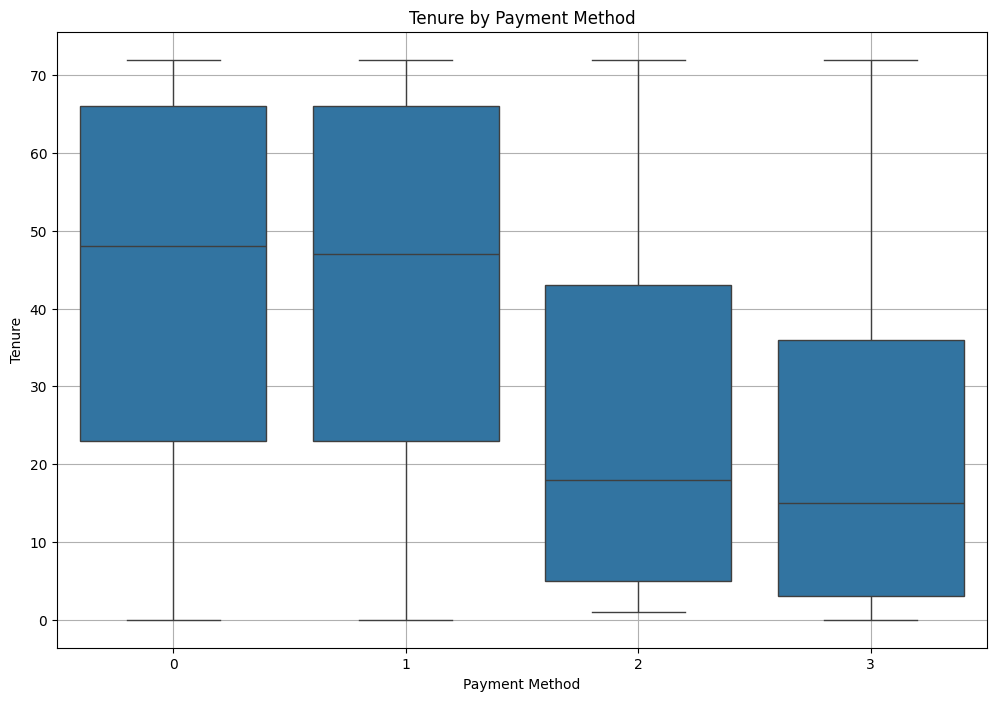

In [6]:


#payment methods vs tenure
plt.figure(figsize=(12,8))
sns.boxplot(x='PaymentMethod', y='tenure', data=df)
plt.title('Tenure by Payment Method')
plt.ylabel('Tenure')
plt.xlabel('Payment Method')
plt.grid(True)
plt.show()



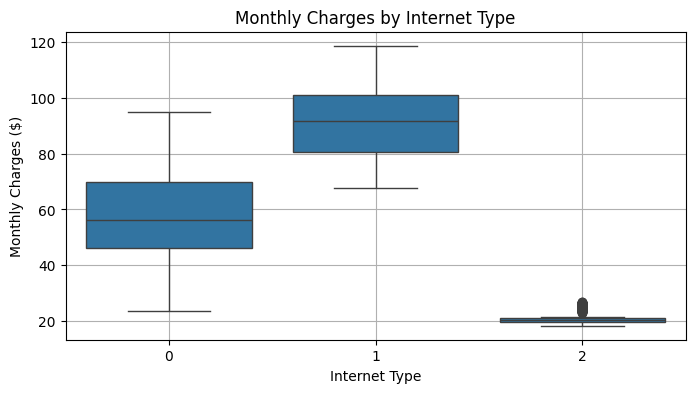

In [7]:
#monthly charges by internet type
plt.figure(figsize=(8,4))
sns.boxplot(x='InternetService', y='MonthlyCharges', data=df)
plt.title('Monthly Charges by Internet Type')
plt.ylabel('Monthly Charges ($)')
plt.xlabel('Internet Type')
plt.grid(True)
plt.show()


In [8]:
# # let us use an some feature engineering to involve and extra variable 
# df['discount'] =df['TotalCharges']-(df['MonthlyCharges']*df['tenure'])

In [9]:

# # churn vs charge difference
# plt.figure(figsize=(8,4))
# sns.boxplot(x='Churn', y='discount', data=)
# plt.title('Discount vs churn')
# plt.ylabel('Discount')
# plt.xlabel('churn')
# plt.grid(True)
# plt.show()



In [10]:
# final preprocessing and checking if everything is working all fine 

df.dropna(inplace=True)
for col in df.columns:
    print(f"Unique values in {col}: {df[col].unique()}")

print(df.isna().sum().sum())


# Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(y.shape , X.shape)
print(df.shape)




Unique values in gender: [0 1]
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: [1 0]
Unique values in Dependents: [0 1]
Unique values in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique values in PhoneService: [0 1]
Unique values in MultipleLines: [0 1]
Unique values in InternetService: [0 1 2]
Unique values in OnlineSecurity: [0 1]
Unique values in OnlineBackup: [1 0]
Unique values in DeviceProtection: [0 1]
Unique values in TechSupport: [0 1]
Unique values in StreamingTV: [0 1]
Unique values in StreamingMovies: [0 1]
Unique values in Contract: [0 1 2]
Unique values in PaperlessBilling: [1 0]
Unique values in PaymentMethod: [2 3 0 1]
Unique values in MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
Unique values in TotalCharges: [  74 3624  536 ... 1265 1157 6151]
Unique values

In [11]:
from sklearn.feature_selection import SelectKBest, chi2

scaler = MinMaxScaler()

 
# discount ranged from negative to positive indicating some absurd level of data as data became unrelated with tenure 
# we can maybe force the discount to also be in the same space as all 

print(y.shape , X.shape)
df_copy = df
len(df.columns)

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.25 ,random_state=42)
X = scaler.fit_transform(X_train)



print(X_train.shape)
# Use SelectKBest to pick the top features
select_k_best = SelectKBest(chi2, k=10)
X_train_new = select_k_best.fit_transform(X_train, y_train)

# Get the selected feature names
selected_features = select_k_best.get_support(indices=True)
print(selected_features)
selected_feature_names = [df.columns[i-1] for i in selected_features]
print('Selected Features:', selected_feature_names)



(7032,) (7032, 20)
(5274, 20)
[ 1  3  4  8 11 14 15 17 18 19]
Selected Features: ['gender', 'Partner', 'Dependents', 'InternetService', 'DeviceProtection', 'StreamingMovies', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [12]:
logreg = LogisticRegression()
rf = RandomForestClassifier(random_state=42)

# Fit the models
logreg.fit(X_train_new, y_train)
rf.fit(X_train_new, y_train)

RandomForestClassifier(random_state=42)

In [13]:
X_test_selected = X_test.iloc[: , selected_features]
print(X_test_selected.shape , X_train_new.shape)
# Logistic Regression evaluation
y_pred_logreg = logreg.predict(X_test_selected)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Logistic Regression Accuracy Score:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, y_pred_logreg))

# Random Forest evaluation
y_pred_rf = rf.predict(X_test_selected)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))


(1758, 10) (5274, 10)
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.62      0.47      0.54       458

    accuracy                           0.79      1758
   macro avg       0.73      0.69      0.70      1758
weighted avg       0.78      0.79      0.78      1758

Logistic Regression Confusion Matrix:
 [[1170  130]
 [ 242  216]]
Logistic Regression Accuracy Score: 0.78839590443686
Logistic Regression ROC AUC Score: 0.6858078602620087
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1300
           1       0.58      0.47      0.52       458

    accuracy                           0.78      1758
   macro avg       0.71      0.68      0.69      1758
weighted avg       0.76      0.78      0.77      1758

Random Forest Confusion Matrix:
 [[1146  154]
 [ 241  217]]
Random Fo

In [1]:
# Cross-validation
logreg_cv_scores = cross_val_score(logreg, X_test_selected, y_test, cv=10)
rf_cv_scores = cross_val_score(rf, X_test_selected, y_test, cv=10)
print("Logistic Regression CV Scores:", logreg_cv_scores)
print("Random Forest CV Scores:", rf_cv_scores)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_new, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_rf = best_rf.predict(X_test_selected)
print("Best Random Forest Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print("Best Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("Best Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_best_rf))
print("Best Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_best_rf))


NameError: name 'cross_val_score' is not defined